# 1. IMPORTS

In [20]:
# necessary libraries
import optuna
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Conv1D, Dense, Flatten, AveragePooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import joblib

# 2. DATA PREPROCESSING FUNCTIONS

In [5]:
# Function that checks Null values
def dataLook(data):
    #print('\n\n- Head -\n')
    #print(data.head())
    
    print('\n\n- Numerical Data -')
    print('\n\nAmount of Null values (Numerical Data):\n')
    print(data[data._get_numeric_data().columns].isnull().sum())

    print('\n\n- Categorical Data -')
    print('\n\nAmount of Null values (Categorical Data):\n')
    data[data.select_dtypes(include=['object']).columns].isnull().sum()
    print(data[data.select_dtypes(include=['object']).columns].isnull().sum())
    

# Dropping unnecessary columns from data
def dropUnnecessaryColumns(data):
    data = data.drop(['Unnamed: 0','Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'],axis = 1)
    return data


# The Tukey Methot
def tukey_method(x):
    x = sorted(x)
 
    i = round(len(x)/2)
    if(len(x) % 2 == 1):
        lower_sample = x[0:i]   
        upper_sample = x[i+1:]
    else:
        
        lower_sample = x[0:i]   
        upper_sample = x[i:]
        
    median_lower = np.median(lower_sample)  #Q1
    median_upper = np.median(upper_sample)  #Q3
    
    # median_upper - median_lower = IQR
    # High outliers = Q3 + 1.5(Q3 – Q1) = Q3 + 1.5(IQR)
    high_outlier = median_upper + 1.5*(median_upper - median_lower) 
    
    #Low outliers = Q1 – 1.5(Q3 – Q1) = Q1 – 1.5(IQR)
    low_outlier =  median_lower - 1.5*(median_upper - median_lower)
    
    return low_outlier, high_outlier


# Function that replaces Null values with calculated mean values without considering outliers
def numericalDataHandling(data):
    numerical = data._get_numeric_data().columns
    for numeric in data[numerical]:
        #sns.boxplot(x=data[numeric])
        non_nullable = data[numeric].dropna()
        print('mean of',data[numeric].name, data[numeric].mean(), 'median of', data[numeric].name, data[numeric].median())
        print('low and high outliers of', non_nullable.name, ':',tukey_method(non_nullable)) 
    
        low_outlier, high_outlier = tukey_method(non_nullable)
        removed = data[(data[numeric] > low_outlier) & (data[numeric] < high_outlier)][numeric]
        print('After removing outliers; mean of', removed.name , removed.mean(),'median of',removed.name, removed.median(),'\n')
        
        # Null values filled with mean value after removing outliers
        data[numeric].fillna(removed.mean(),inplace=True)
        
    print('Amount of Null values (Numerical Data) :')
    data[numerical].isnull().sum()
    print(data[numerical].isnull().sum())
    
    return data


# Function that replace Null values with mode values
def categoricalDataHandling(data):
    # Feature Engineering for Categorical Data 
    data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True) # set No to 0, Yes 10 1
    
    categorical = data.select_dtypes(include=['object']).columns
    for categoric in data[categorical]:
        mode_value = data[categoric].mode() # Null variables filled with mode value
        print('Mode of', data[categoric].name, ':',mode_value[0])
        data[categoric].fillna(mode_value[0], inplace = True)
    
    print('\nAmount of Null values (Categorical Data):')
    data[categorical].isnull().sum()
    print(data[categorical].isnull().sum())
    
    data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True) # set No to 0, Yes 10 1
    
    return data, categorical


# Function that balance dataset with removing data (label RainTomorrow with value No)   
def balanceDataset(data):
    # To get a balanced dataset some rows deleted randomly from label 0 (RainTomorrow = No)
    no_count = len(data[(data['RainTomorrow'] == 0)])
    yes_count = len(data[(data['RainTomorrow'] == 1)])
    
    data = data.sample(frac = 1, random_state = 11) # shuffle rows
    no_index = data[(data['RainTomorrow'] == 0)].index
    
    data = data.drop(no_index[0:no_count-yes_count])
    
    return data


# Function that converts categorical data to numerical
def categorical_to_numerical(data):
    a = list(set(list(data['WindGustDir'])))
    c = list(data.select_dtypes(include=['object']).columns)
    for i in range(len(a)):
        for j in range(len(c)):
            data[c[j]].replace({a[i]: i+1},inplace = True)
        
    #print(data.head())
    
    labels = data['RainTomorrow']
    data = data.drop(['RainTomorrow'], axis = 1)
    col = data.columns

    return data, col, labels


# Feature Scaling
def featureScaling(data, col):
    #Feature Scaling    
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    #print(pd.DataFrame(data, columns = [col]),'\n')
    #print(pd.DataFrame(data, columns = [col]).describe())
    
    return data


# Data preprosessing   
def divideTrainTest(data, labels):    
    train, test, train_label, test_label = train_test_split(data,labels,test_size=0.25, random_state = 11)
    return train, test, train_label, test_label

def preparingDataforCNN(train, test, train_label, test_label):
    train_label = to_categorical(train_label, num_classes = 2) 
    test_label = to_categorical(test_label, num_classes = 2)    
    
    # reshape for 1D CNN 
    train = train.reshape(train.shape[0], test.shape[1], 1)
    test = test.reshape(test.shape[0], test.shape[1], 1)
    
    return train, test, train_label, test_label

# 3. DATA PREPROCESSING

In [6]:
# LOAD DATA
data = pd.read_csv('weather.csv')
data.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [7]:
# LOOK TO DATA
dataLook(data)



- Numerical Data -


Amount of Null values (Numerical Data):

Unnamed: 0           0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
dtype: int64


- Categorical Data -


Amount of Null values (Categorical Data):

Date                0
Location            0
WindGustDir      9330
WindDir9am      10013
WindDir3pm       3778
RainToday        1406
RainTomorrow        0
dtype: int64


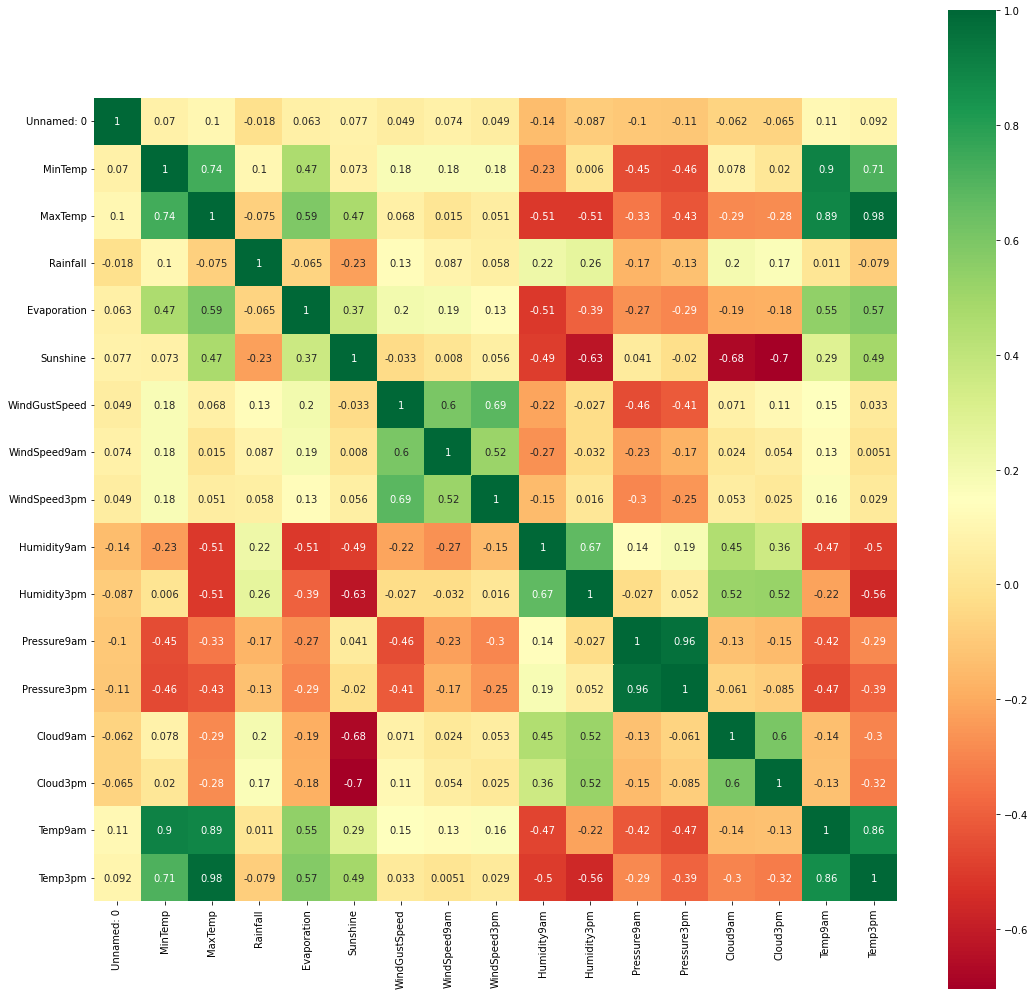

In [6]:
# CORRELATION MATRIX OF NUMERIC DATA
corrmat = data._get_numeric_data().corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap='RdYlGn',annot=True, square=True)

In [8]:
# DROP UNNECESSARY COLUMN
data = dropUnnecessaryColumns(data)
data.head()

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


In [9]:
# FILL NULL VALUES IN THE NUMERICAL DATA WITH PROPER VALUES
data = numericalDataHandling(data)

mean of MinTemp 12.186399728729265 median of MinTemp 12.0
low and high outliers of MinTemp : (-6.200000000000001, 30.6)
After removing outliers; mean of MinTemp 12.192042065387929 median of MinTemp 12.0 

mean of MaxTemp 23.226784191272355 median of MaxTemp 22.6
low and high outliers of MaxTemp : (2.4499999999999975, 43.65)
After removing outliers; mean of MaxTemp 23.249323254037847 median of MaxTemp 22.6 

mean of Rainfall 2.349974074310838 median of Rainfall 0.0
low and high outliers of Rainfall : (-1.2000000000000002, 2.0)
After removing outliers; mean of Rainfall 0.13864320949927972 median of Rainfall 0.0 

mean of WindGustSpeed 39.98429165757619 median of WindGustSpeed 39.0
low and high outliers of WindGustSpeed : (5.5, 73.5)
After removing outliers; mean of WindGustSpeed 39.00921357482085 median of WindGustSpeed 37.0 

mean of WindSpeed9am 14.001988000994 median of WindSpeed9am 13.0
low and high outliers of WindSpeed9am : (-11.0, 37.0)
After removing outliers; mean of WindSpeed9a

In [10]:
# FILL NULL VALUES IN THE CATEGORICAL DATA WITH PROPER VALUES
data, categorical = categoricalDataHandling(data)

Mode of WindGustDir : W
Mode of WindDir9am : N
Mode of WindDir3pm : SE
Mode of RainToday : No

Amount of Null values (Categorical Data):
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
dtype: int64


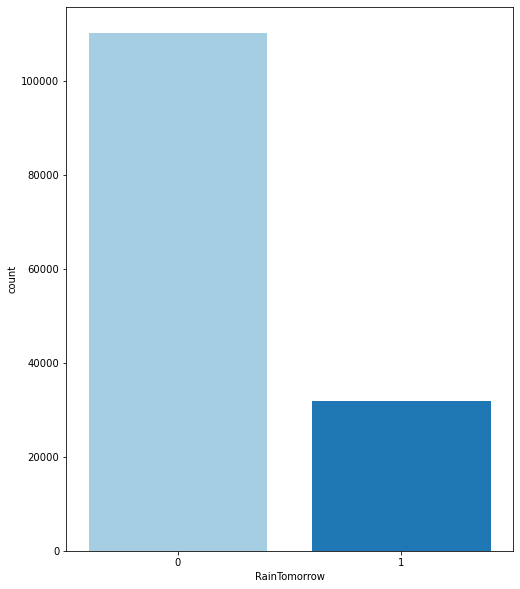

In [10]:
# RAIN TOMORROW VISUALIZATION
# 0 means No, 1 means Yes
f, ax = plt.subplots(figsize=(8, 10))
ax = sns.countplot(x = 'RainTomorrow', data=data, palette = 'Paired', saturation = 2)
plt.show()

In [11]:
# BALANCE DATASET VIA EQUALIZING YES NO COUNTS OF RAIN TOMORROW COLUMN
data = balanceDataset(data)
data.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000
mean,12.563889,22.494020,3.641392,41.861058,14.540039,19.100849,72.052351,57.475561,1016.604489,1014.304199,16.894772,20.838128,0.305142,0.500000
std,6.374417,7.123007,10.938941,14.171497,9.145096,9.101021,18.468507,21.576522,6.956980,6.894538,6.427430,6.890618,0.460471,0.500004
min,-7.800000,-4.100000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,-7.000000,-5.100000,0.000000,0.000000
25%,8.000000,17.200000,0.000000,31.000000,7.000000,13.000000,61.000000,43.000000,1012.300000,1009.900000,12.200000,15.800000,0.000000,0.000000
50%,12.300000,21.800000,0.000000,39.009214,13.000000,19.000000,73.000000,58.000000,1017.500000,1015.200000,16.600000,20.300000,0.000000,0.500000
75%,17.200000,27.500000,2.200000,50.000000,20.000000,24.000000,87.000000,73.000000,1020.800000,1018.500000,21.400000,25.400000,1.000000,1.000000
max,33.900000,46.800000,371.000000,135.000000,130.000000,87.000000,100.000000,100.000000,1040.900000,1038.500000,39.400000,46.100000,1.000000,1.000000


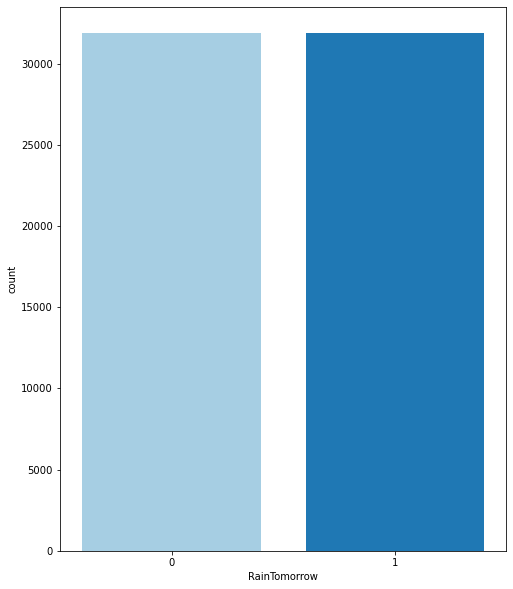

In [12]:
# RAIN TOMORROW VISUALIZATION
# 0 means No, 1 means Yes
f, ax = plt.subplots(figsize=(8, 10))
ax = sns.countplot(x = 'RainTomorrow', data=data, palette = 'Paired', saturation = 2)
plt.show()

In [12]:
# CONVERTING CATEGORICAL DATA TO NUMERICAL DATA
data, col, labels = categorical_to_numerical(data)
data.head()

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday
18674,16.6,21.5,8.0,4,67.000000,14,14,2.0,15.000000,91.0,87.000000,1011.000000,1008.400000,19.2,20.500000,1
90892,24.3,27.8,95.2,3,37.000000,3,3,9.0,24.000000,94.0,94.000000,1007.200000,1006.200000,25.7,25.500000,1
110527,9.4,15.6,15.0,11,81.000000,10,5,19.0,17.000000,77.0,73.000000,1007.500000,1001.900000,13.0,13.900000,1
17399,4.8,17.0,3.2,5,39.009214,12,14,0.0,18.155859,67.0,51.482606,1017.757684,1015.322676,11.2,21.688981,1
83032,14.9,24.9,0.0,14,39.000000,4,14,7.0,9.000000,61.0,69.000000,1027.900000,1026.400000,21.1,21.000000,0


In [13]:
# FEATURE SCALING 
data = featureScaling(data, col)
pd.DataFrame(data, columns = [col]).head()

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday
0,0.585132,0.502947,0.021563,0.200000,0.468750,0.866667,0.866667,0.015385,0.172414,0.91,0.870000,0.504967,0.509772,0.564655,0.500000,1.0
1,0.769784,0.626719,0.256604,0.133333,0.234375,0.133333,0.133333,0.069231,0.275862,0.94,0.940000,0.442053,0.473941,0.704741,0.597656,1.0
2,0.412470,0.387033,0.040431,0.666667,0.578125,0.600000,0.266667,0.146154,0.195402,0.77,0.730000,0.447020,0.403909,0.431034,0.371094,1.0
3,0.302158,0.414538,0.008625,0.266667,0.250072,0.733333,0.866667,0.000000,0.208688,0.67,0.514826,0.616849,0.622519,0.392241,0.523222,1.0
4,0.544365,0.569745,0.000000,0.866667,0.250000,0.200000,0.866667,0.053846,0.103448,0.61,0.690000,0.784768,0.802932,0.605603,0.509766,0.0


In [14]:
# DATA DESCRIBE AFTER FEATURE SCALING
pd.DataFrame(data, columns = [col]).describe()

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday
count,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000,63754.000000
mean,0.488343,0.522476,0.009815,0.488372,0.272352,0.532244,0.510797,0.111846,0.219550,0.720524,0.574756,0.597756,0.605932,0.514974,0.506604,0.305142
std,0.152864,0.139941,0.029485,0.307581,0.110715,0.300119,0.314079,0.070347,0.104609,0.184685,0.215765,0.115182,0.112289,0.138522,0.134582,0.460471
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.378897,0.418468,0.000000,0.266667,0.187500,0.266667,0.266667,0.053846,0.149425,0.610000,0.430000,0.526490,0.534202,0.413793,0.408203,0.000000
50%,0.482014,0.508841,0.000000,0.466667,0.250072,0.600000,0.533333,0.100000,0.218391,0.730000,0.580000,0.612583,0.620521,0.508621,0.496094,0.000000
75%,0.599520,0.620825,0.005930,0.733333,0.335938,0.733333,0.800000,0.153846,0.275862,0.870000,0.730000,0.667219,0.674267,0.612069,0.595703,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 4. 1D CNN TRAINING FUNCTION WITH OPTUNA

In [21]:
# Objective function of Optuna. Optuna is used to decide best hyperparameters.
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    
    global model_list
    global test
    global test_label
    
    train, test, train_label, test_label = divideTrainTest(data, labels)
    train, test, train_label, test_label = preparingDataforCNN(train, test, train_label, test_label)
    
    
    set1 = [128, 64, 32]
    set2 = [64, 32, 16]
    set3 = [16, 32, 64]
    true_set = []
    sets = trial.suggest_categorical("filters", ["set1", "set2", "set3"])
    if(sets == "set1"):
        true_set = set1
    elif(sets == "set2"):
        true_set = set2
    elif(sets == "set3"):
        true_set = set3
        
    model = Sequential()
    
    model.add(
        Conv1D(
            filters = true_set[0],
            kernel_size = trial.suggest_categorical("kernel_size1", [5, 7]),
            strides = trial.suggest_categorical("strides1", [1, 2]),
            activation = trial.suggest_categorical("activation1", ["relu", "linear"]),
            padding='same',
            input_shape = (train[0].shape)
        )
    )
    
    model.add(AveragePooling1D(pool_size = 2, strides=None))
    
    dropout_rate = trial.suggest_float("rate1", 0.1, 0.3, log=True)
    model.add(Dropout(dropout_rate))
    
    model.add(
        Conv1D(
            filters = true_set[1],
            kernel_size = trial.suggest_categorical("kernel_size2", [3, 5]),
            strides = trial.suggest_categorical("strides2", [1, 2]),
            activation = trial.suggest_categorical("activation2", ["relu", "linear"]),
            padding='same'
        )
    )
    
    model.add(AveragePooling1D(pool_size = 2, strides=None))
    
    dropout_rate2 = trial.suggest_float("rate2", 0.1, 0.3, log=True)
    model.add(Dropout(dropout_rate2))
    
    model.add(
        Conv1D(
            filters = true_set[2],
            kernel_size = trial.suggest_categorical("kernel_size3", [3]),
            strides = trial.suggest_categorical("strides3", [1, 2]),
            activation = trial.suggest_categorical("activation3", ["relu", "linear"]),
            padding='same'
        )
    )
        
    model.add(Flatten())
    
    units = trial.suggest_int('unit1', 30, 50)
    model.add(Dense(units, activation='relu'))
    
    units2 = trial.suggest_int('unit2', 10, 20)
    model.add(Dense(units2, activation='relu'))
    
    model.add(Dense(2, activation='softmax'))
    
    
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_1 = optimizers.Adam(lr = lr)
    optimizer_2 = optimizers.SGD(lr = lr)
    optimizer_3 = optimizers.RMSprop(lr = lr)
    optimizer = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"]) 
    if (optimizer == "Adam"):
        optimizer = optimizer_1
    elif (optimizer == "SGD"):
        optimizer = optimizer_2
    else:
        optimizer = optimizer_3
    
    model.compile(
        optimizer = optimizer,
        loss = 'binary_crossentropy',
        metrics = ['accuracy'],
    )
    
    earlystop_patience = trial.suggest_int('early stop patience', 5, 20)
    es = EarlyStopping(monitor='val_loss', mode='min', patience=earlystop_patience,  restore_best_weights=True)

    model.fit(train, train_label, epochs=100, validation_data=(test,test_label), batch_size=32, callbacks=[es], verbose=0)

    loss, acc = model.evaluate(test, test_label, verbose=0)
    
    model_list.append(acc)
    model_save(model, model_list, acc)
   
    return acc    

def model_save(model, model_list, acc):
    if acc >= max(model_list):
        model.save("model\\best_model.h5")

# 5. 1D CNN TRAINING / RESULTS

In [16]:
model_list = []

test = []
test_label = []

# 3 hours to find best parameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=21600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-12-13 23:57:28,258] A new study created in memory with name: no-name-db39338c-fe3d-439e-9954-9de6a40a177d


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[I 2021-12-14 00:00:00,756] Trial 0 finished with value: 0.7615283131599426 and parameters: {'filters': 'set1', 'kernel_size1': 5, 'strides1': 1, 'activation1': 'linear', 'rate1': 0.28357925474380036, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'relu', 'rate2': 0.2897774215056033, 'kernel_size3': 3, 'strides3': 1, 'activation3': 'linear', 'unit1': 37, 'unit2': 17, 'lr': 0.003296102181512506, 'optimizer': 'RMSprop', 'early stop patience': 13}. Best is trial 0 with value: 0.7615283131599426.
[I 2021-12-14 00:04:35,309] Trial 1 finished with value: 0.759834349155426 and parameters: {'filters': 'set1', 'kernel_size1': 7, 'strides1': 1, 'activation1': 'linear', 'rate1': 0.19967667653039092, 'kernel_size2': 3, 'strides2': 2, 'activation2': 'linear', 'rate2': 0.23221578574239043, 'kernel_size3': 3, 'strides3': 1, 'activation3': 'linear', 'unit1': 44, 'unit2': 12, 'lr': 0.004311895564327837, 'optimizer': 'Adam', 'early stop patience': 16}. Best is trial 0 with value: 0.7615283131599426.
[

[I 2021-12-14 04:00:04,109] Trial 17 finished with value: 0.7803500890731812 and parameters: {'filters': 'set3', 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'rate1': 0.1424184617769177, 'kernel_size2': 3, 'strides2': 2, 'activation2': 'relu', 'rate2': 0.24839959611764315, 'kernel_size3': 3, 'strides3': 2, 'activation3': 'relu', 'unit1': 48, 'unit2': 13, 'lr': 0.0005390428220071413, 'optimizer': 'Adam', 'early stop patience': 17}. Best is trial 17 with value: 0.7803500890731812.
[I 2021-12-14 04:20:41,621] Trial 18 finished with value: 0.7643516063690186 and parameters: {'filters': 'set2', 'kernel_size1': 7, 'strides1': 1, 'activation1': 'relu', 'rate1': 0.1348707323637692, 'kernel_size2': 5, 'strides2': 2, 'activation2': 'relu', 'rate2': 0.24533006223486692, 'kernel_size3': 3, 'strides3': 1, 'activation3': 'relu', 'unit1': 48, 'unit2': 13, 'lr': 0.0005867773433119664, 'optimizer': 'SGD', 'early stop patience': 17}. Best is trial 17 with value: 0.7803500890731812.
[I 2021-1

Number of finished trials: 25
Best trial:
  Value: 0.7817930579185486
  Params: 
    filters: set3
    kernel_size1: 5
    strides1: 1
    activation1: relu
    rate1: 0.1284103755120651
    kernel_size2: 3
    strides2: 2
    activation2: relu
    rate2: 0.25306738769867404
    kernel_size3: 3
    strides3: 2
    activation3: relu
    unit1: 45
    unit2: 14
    lr: 0.0010164598785666857
    optimizer: Adam
    early stop patience: 14


In [17]:
# LOAD SAVED BEST MODEL
model2 = models.load_model('model\\best_model.h5')
loss, acc = model2.evaluate(test, test_label, verbose=0)
print('loss:',loss)
print('acc:',acc)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
loss: 0.4589816172913944
acc: 0.78179306


C:\Users\Burla Nur\Anaconda3\envs\my_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


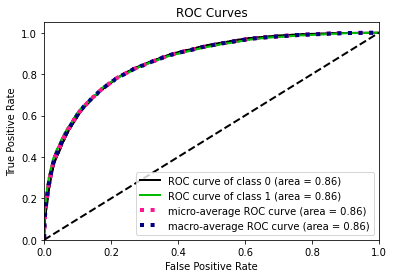

In [18]:
# ROC CURVES
y_true = test_label
y_prob =  model2.predict(test)
y_true = np.argmax(y_true, axis=1)       
skplt.metrics.plot_roc_curve(y_true, y_prob)
plt.show()

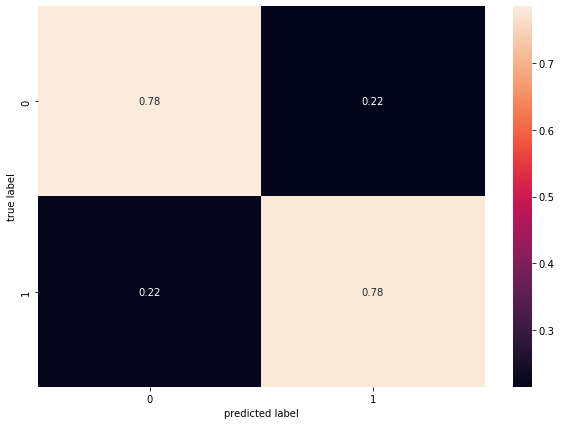

In [19]:
# CONFUSION MATRIX   
# 0 means No, 1 means Yes
y_probs = []
for i in range(len(test_label)):
    if y_prob[i][0] > y_prob[i][1]:
        y_probs.append(0)
    elif y_prob[i][0] < y_prob[i][1]:
        y_probs.append(1)

matrix = confusion_matrix(y_true, y_probs, normalize='true') 
plt.figure(figsize = (10,7))
ax = sns.heatmap(matrix, annot=True)
ax.set(xlabel='predicted label', ylabel='true label')
plt.show()

# 6. MACHINE LEARNING TRAINING FUNCTION WITH OPTUNA

In [20]:
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    
    global model_list
    global test_ml
    global test_label_ml
    
    train, test_ml, train_label, test_label_ml = divideTrainTest(data, labels)  
    
    clf1 = LogisticRegression(
        penalty = trial.suggest_categorical('penalty',['none', 'l2']),
        C = trial.suggest_float('LogisticRegression C', 0.1, 100, log=True),
        random_state = 11, verbose = 2
    )
    
    clf2 = SVC(
        C = trial.suggest_float('SVC C', 0.1, 100, log=True),
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf']),
        gamma = trial.suggest_float('gamma', 0.0001, 10, log=True),
        random_state = 11, verbose = 2
    )
    
    classifier_selection = trial.suggest_categorical('classifiers', ['clf1', 'clf2'])
     
    if (classifier_selection == 'clf1'):
        clf = clf1
    else:
        clf = clf2
        
    clf.fit(train,train_label)
    accuracy = clf.score(test_ml, test_label_ml)
    
    model_list.append(accuracy)
    ml_model_save(clf, model_list, accuracy)

    return accuracy
            

def ml_model_save(model, model_list, acc):
    if acc >= max(model_list):
        joblib.dump(model, 'ml_model\\best_ml_model.sav')

# 7. TRAINING / RESULTS

In [ ]:
model_list = []

test_ml = []
test_label_ml = []

# 3 hours to find best parameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=21600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-12-14 06:10:05,237] A new study created in memory with name: no-name-b340c966-8b77-4275-92f6-e0681ac816d5


[LibSVM]

[I 2021-12-14 06:11:29,204] Trial 0 finished with value: 0.7621557186774578 and parameters: {'penalty': 'none', 'LogisticRegression C': 10.94765688771515, 'SVC C': 0.6197010161971082, 'kernel': 'rbf', 'gamma': 0.0175485477733824, 'classifiers': 'clf2'}. Best is trial 0 with value: 0.7621557186774578.


[LibSVM]

[I 2021-12-14 06:13:01,865] Trial 1 finished with value: 0.7701235962105527 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.17122952412637052, 'SVC C': 24.831033745375372, 'kernel': 'linear', 'gamma': 0.00029999068648783525, 'classifiers': 'clf2'}. Best is trial 1 with value: 0.7701235962105527.


[LibSVM]

[I 2021-12-14 09:06:24,028] Trial 2 finished with value: 0.7824832172658259 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.8470687777544668, 'SVC C': 0.16660122671140715, 'kernel': 'poly', 'gamma': 9.153898974452696, 'classifiers': 'clf2'}. Best is trial 2 with value: 0.7824832172658259.


[LibSVM]

[I 2021-12-14 09:07:13,913] Trial 3 finished with value: 0.7678022460631156 and parameters: {'penalty': 'l2', 'LogisticRegression C': 3.0008013471149515, 'SVC C': 0.24248703939845487, 'kernel': 'linear', 'gamma': 0.0004850242519883159, 'classifiers': 'clf2'}. Best is trial 2 with value: 0.7824832172658259.


[LibSVM]

[I 2021-12-14 09:09:22,353] Trial 4 finished with value: 0.7698726394378568 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.10536742039123602, 'SVC C': 47.79726864629983, 'kernel': 'linear', 'gamma': 0.24813994572437972, 'classifiers': 'clf2'}. Best is trial 2 with value: 0.7824832172658259.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Burla Nur\Anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s rema

[LibSVM]

[I 2021-12-14 09:10:21,178] Trial 6 finished with value: 0.7634105025409373 and parameters: {'penalty': 'l2', 'LogisticRegression C': 5.299716372839514, 'SVC C': 47.03449579335855, 'kernel': 'poly', 'gamma': 0.026439852220229255, 'classifiers': 'clf2'}. Best is trial 2 with value: 0.7824832172658259.
C:\Users\Burla Nur\Anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Burla Nur\Anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation fo

[LibSVM]

[I 2021-12-14 09:11:11,539] Trial 8 finished with value: 0.7681786812221595 and parameters: {'penalty': 'l2', 'LogisticRegression C': 6.42800213012584, 'SVC C': 0.5953300460485271, 'kernel': 'linear', 'gamma': 0.0016025471999691191, 'classifiers': 'clf2'}. Best is trial 2 with value: 0.7824832172658259.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Burla Nur\Anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remain

[LibSVM]

[I 2021-12-14 09:15:45,704] Trial 14 finished with value: 0.7787816048685614 and parameters: {'penalty': 'l2', 'LogisticRegression C': 1.9622489283267273, 'SVC C': 0.29754682837811686, 'kernel': 'poly', 'gamma': 1.975822715315462, 'classifiers': 'clf2'}. Best is trial 2 with value: 0.7824832172658259.


[LibSVM]

[I 2021-12-14 09:19:16,076] Trial 15 finished with value: 0.7783424305163436 and parameters: {'penalty': 'none', 'LogisticRegression C': 1.8367719445542368, 'SVC C': 0.2877603474103918, 'kernel': 'poly', 'gamma': 1.7883094146563132, 'classifiers': 'clf2'}. Best is trial 2 with value: 0.7824832172658259.


[LibSVM]

[I 2021-12-14 09:21:43,784] Trial 16 finished with value: 0.7861220904699165 and parameters: {'penalty': 'l2', 'LogisticRegression C': 0.2991748629370253, 'SVC C': 7.284452261360448, 'kernel': 'rbf', 'gamma': 2.252565649742578, 'classifiers': 'clf2'}. Best is trial 16 with value: 0.7861220904699165.


[LibSVM]

[I 2021-12-14 09:23:24,643] Trial 17 finished with value: 0.7853064809586549 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.2802435559499975, 'SVC C': 7.63625917108123, 'kernel': 'rbf', 'gamma': 1.1160308315611267, 'classifiers': 'clf2'}. Best is trial 16 with value: 0.7861220904699165.


[LibSVM]

[I 2021-12-14 09:25:30,768] Trial 18 finished with value: 0.7858083945040467 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.3038639503435305, 'SVC C': 12.075257412931826, 'kernel': 'rbf', 'gamma': 1.1668274419604234, 'classifiers': 'clf2'}. Best is trial 16 with value: 0.7861220904699165.


[LibSVM]

[I 2021-12-14 09:26:48,035] Trial 19 finished with value: 0.7760838195620804 and parameters: {'penalty': 'l2', 'LogisticRegression C': 0.37074227239731933, 'SVC C': 14.823607088541321, 'kernel': 'rbf', 'gamma': 0.08556488404571375, 'classifiers': 'clf2'}. Best is trial 16 with value: 0.7861220904699165.


[LibSVM]

[I 2021-12-14 09:28:05,412] Trial 20 finished with value: 0.7747035573122529 and parameters: {'penalty': 'l2', 'LogisticRegression C': 0.1997824182763678, 'SVC C': 5.493304126111406, 'kernel': 'rbf', 'gamma': 0.09084746987712114, 'classifiers': 'clf2'}. Best is trial 16 with value: 0.7861220904699165.


[LibSVM]

[I 2021-12-14 09:30:13,067] Trial 21 finished with value: 0.7856829161176987 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.2846223708469368, 'SVC C': 10.056350990894549, 'kernel': 'rbf', 'gamma': 1.2910171272920643, 'classifiers': 'clf2'}. Best is trial 16 with value: 0.7861220904699165.


[LibSVM]

[I 2021-12-14 09:34:26,265] Trial 22 finished with value: 0.7852437417654808 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.10195230441372592, 'SVC C': 15.717640878529233, 'kernel': 'rbf', 'gamma': 2.5737051983771533, 'classifiers': 'clf2'}. Best is trial 16 with value: 0.7861220904699165.


[LibSVM]

[I 2021-12-14 09:39:10,851] Trial 23 finished with value: 0.787565091912918 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.3968064079107413, 'SVC C': 80.30161564418209, 'kernel': 'rbf', 'gamma': 0.6791700860838945, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 09:43:20,024] Trial 24 finished with value: 0.7860593512767425 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.4282057982143948, 'SVC C': 83.58625130167312, 'kernel': 'rbf', 'gamma': 0.5572812127255543, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 09:47:20,213] Trial 25 finished with value: 0.7867494824016563 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.5593101148270552, 'SVC C': 99.13402811523869, 'kernel': 'rbf', 'gamma': 0.45399051274447916, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 09:54:43,338] Trial 26 finished with value: 0.7790325616412573 and parameters: {'penalty': 'none', 'LogisticRegression C': 1.0002228681946659, 'SVC C': 30.94460607546679, 'kernel': 'rbf', 'gamma': 3.03397809036113, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 09:56:25,713] Trial 27 finished with value: 0.7792207792207793 and parameters: {'penalty': 'none', 'LogisticRegression C': 1.4856258965963998, 'SVC C': 89.6255640659067, 'kernel': 'rbf', 'gamma': 0.10787801268811298, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 09:59:30,103] Trial 28 finished with value: 0.7861848296630906 and parameters: {'penalty': 'l2', 'LogisticRegression C': 0.1587038476670696, 'SVC C': 50.46695001876273, 'kernel': 'rbf', 'gamma': 0.6034252494308883, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:00:48,164] Trial 29 finished with value: 0.7723822071648159 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.17219133178023696, 'SVC C': 60.237155139293215, 'kernel': 'rbf', 'gamma': 0.009042516978879535, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:02:18,343] Trial 30 finished with value: 0.7551289290419725 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.5987168740185732, 'SVC C': 27.94156160744134, 'kernel': 'rbf', 'gamma': 0.00010808802911117214, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:05:53,723] Trial 31 finished with value: 0.7863103080494385 and parameters: {'penalty': 'l2', 'LogisticRegression C': 0.188608486595497, 'SVC C': 60.45789082615579, 'kernel': 'rbf', 'gamma': 0.6218159701292323, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:09:41,900] Trial 32 finished with value: 0.7866240040153084 and parameters: {'penalty': 'l2', 'LogisticRegression C': 0.14796776979567117, 'SVC C': 59.823560646483436, 'kernel': 'rbf', 'gamma': 0.677881942994509, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:11:50,353] Trial 33 finished with value: 0.7803500846979108 and parameters: {'penalty': 'l2', 'LogisticRegression C': 0.16408553618911048, 'SVC C': 98.32404607331601, 'kernel': 'rbf', 'gamma': 0.1692010694803963, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:20:21,228] Trial 34 finished with value: 0.7716293368467282 and parameters: {'penalty': 'l2', 'LogisticRegression C': 0.47084732246468236, 'SVC C': 23.236105340432722, 'kernel': 'rbf', 'gamma': 4.298016377333796, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:22:13,023] Trial 35 finished with value: 0.7701235962105527 and parameters: {'penalty': 'l2', 'LogisticRegression C': 0.11513526459999748, 'SVC C': 35.45422183443008, 'kernel': 'linear', 'gamma': 0.049616273878942616, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:26:02,353] Trial 36 finished with value: 0.7863103080494385 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.2215267144745858, 'SVC C': 64.57599936175004, 'kernel': 'rbf', 'gamma': 0.6271533570974505, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:27:25,479] Trial 37 finished with value: 0.7702490745969007 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.8051647158196582, 'SVC C': 19.645494207950748, 'kernel': 'linear', 'gamma': 0.2165393002639913, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:28:44,283] Trial 38 finished with value: 0.7754564276303407 and parameters: {'penalty': 'none', 'LogisticRegression C': 3.623798833497608, 'SVC C': 37.85815907375171, 'kernel': 'rbf', 'gamma': 0.04172127220621944, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:34:09,441] Trial 39 finished with value: 0.7868122215948303 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.24926496086194166, 'SVC C': 73.06940481692908, 'kernel': 'rbf', 'gamma': 0.8529900243569857, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:36:58,959] Trial 40 finished with value: 0.7699353786310308 and parameters: {'penalty': 'none', 'LogisticRegression C': 10.061266282356428, 'SVC C': 74.21699458819549, 'kernel': 'linear', 'gamma': 4.098599264480223, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:39:15,133] Trial 41 finished with value: 0.7843026538678712 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.260403573114842, 'SVC C': 44.90485849306012, 'kernel': 'rbf', 'gamma': 0.4144956377282081, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:44:05,578] Trial 42 finished with value: 0.7870004391743523 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.13479881793013065, 'SVC C': 65.0505523335676, 'kernel': 'rbf', 'gamma': 0.8599799679917524, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 10:50:26,816] Trial 43 finished with value: 0.7873141351402221 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.1186941488583445, 'SVC C': 89.74206518409338, 'kernel': 'rbf', 'gamma': 0.8965632706523284, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.
C:\Users\Burla Nur\Anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Burla Nur\Anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation f

[LibSVM]

[I 2021-12-14 10:51:45,687] Trial 45 finished with value: 0.780036388732041 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.42399665058551084, 'SVC C': 1.2593503018362038, 'kernel': 'rbf', 'gamma': 1.0243437406744453, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 11:11:13,638] Trial 46 finished with value: 0.7534977100194491 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.7256545168620672, 'SVC C': 44.1717566571286, 'kernel': 'rbf', 'gamma': 5.117487852650306, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.
C:\Users\Burla Nur\Anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Burla Nur\Anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

[LibSVM]

[I 2021-12-14 11:13:59,214] Trial 48 finished with value: 0.7699353786310308 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.22088606039258307, 'SVC C': 72.45657276018612, 'kernel': 'linear', 'gamma': 0.0161344066330363, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 11:15:22,986] Trial 49 finished with value: 0.7781542129368216 and parameters: {'penalty': 'none', 'LogisticRegression C': 1.2591250258437587, 'SVC C': 26.901129941759486, 'kernel': 'rbf', 'gamma': 0.12430746141247988, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.
C:\Users\Burla Nur\Anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Burla Nur\Anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation

[LibSVM]

[I 2021-12-14 11:20:02,548] Trial 51 finished with value: 0.7870631783675262 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.14329777051070505, 'SVC C': 59.73181038846475, 'kernel': 'rbf', 'gamma': 0.8800811436040039, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 11:27:23,961] Trial 52 finished with value: 0.7866240040153084 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.33079527095877365, 'SVC C': 99.6290149692395, 'kernel': 'rbf', 'gamma': 0.9821360583925682, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 11:29:45,458] Trial 53 finished with value: 0.7841771754815233 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.1382805740086705, 'SVC C': 50.9188533542784, 'kernel': 'rbf', 'gamma': 0.39464623983061525, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 11:32:05,667] Trial 54 finished with value: 0.782420478072652 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.2317810541895349, 'SVC C': 67.50083965083624, 'kernel': 'rbf', 'gamma': 0.28674887726062886, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 11:44:51,762] Trial 55 finished with value: 0.7605872388481084 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.1043043686839807, 'SVC C': 22.133386889736634, 'kernel': 'rbf', 'gamma': 5.807432467619604, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 11:46:30,403] Trial 56 finished with value: 0.49469853817679904 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.5366473566092491, 'SVC C': 43.01469453417734, 'kernel': 'poly', 'gamma': 0.002318473962463648, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 11:52:04,283] Trial 57 finished with value: 0.7874396135265701 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.3532115242112735, 'SVC C': 72.91387327783124, 'kernel': 'rbf', 'gamma': 0.925665891434569, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.


[LibSVM]

[I 2021-12-14 11:55:12,108] Trial 58 finished with value: 0.7866867432084823 and parameters: {'penalty': 'none', 'LogisticRegression C': 0.3561876801536106, 'SVC C': 17.12942494383322, 'kernel': 'rbf', 'gamma': 1.6393556153081776, 'classifiers': 'clf2'}. Best is trial 23 with value: 0.787565091912918.
C:\Users\Burla Nur\Anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Burla Nur\Anaconda3\envs\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation f

[LibSVM]

In [15]:
ml_model = joblib.load('ml_model\\best_ml_model.sav')

C:\Users\Burla Nur\Anaconda3\envs\my_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


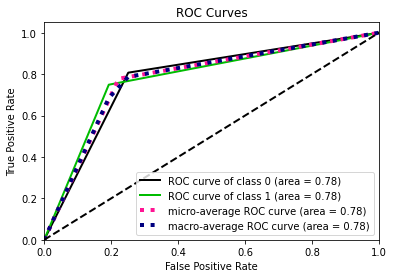

In [18]:
#ROC curves
y_true = test_label_ml
y_prob =  ml_model.predict(test_ml) 
t = np.zeros((len(test_label_ml), 2))
for i in range(len(test_label_ml)):
    if(y_prob[i] == 0):
        t[i][0] = 1
    else:
        t[i][1] = 1
        
skplt.metrics.plot_roc_curve(y_true, t)
plt.show()

[Text(69.0, 0.5, 'true label'), Text(0.5, 42.0, 'predicted label')]

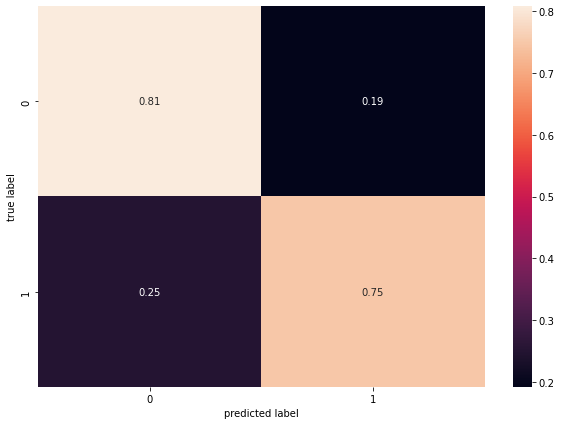

In [19]:
#confusion matrix   
matrix = confusion_matrix(y_true, y_prob,normalize='true') 
plt.figure(figsize = (10,7))
ax = sns.heatmap(matrix, annot=True)
ax.set(xlabel='predicted label', ylabel='true label')